# Most general form of cross-validation
---

This provides no personalization, and still avoids the issue of using a subject's future data for prediction.

In [1]:
%pylab --no-import-all inline

from os import path
import sys

import pandas as pd
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler

# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = path.join("..", 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport features.build_features
%aimport visualization.visualize
from features.build_features import previous_value
from visualization.visualize import modified_bland_altman_plot

Populating the interactive namespace from numpy and matplotlib


In [2]:
file = path.join("..", "data", "processed", "df.csv")
df = pd.read_csv(file, index_col=0)

## Compute features

In [3]:
features = []

### Previous `L_PREOVULATION` and `L_CYCLE`

In [4]:
df['past_L_PREOVULATION'] = previous_value('L_PREOVULATION', df)
df['past_L_CYCLE'] = previous_value('L_CYCLE', df)

df.dropna(subset=[
    'past_L_PREOVULATION', 
    'past_L_CYCLE'
], inplace=True)

features += ['past_L_PREOVULATION', 'past_L_CYCLE']

### $n$ days of temperature measurements.

The use case requires deleting those whose ovulation occurs before these $n$ days.

In [5]:
NUMBER_OF_DAYS = 10
df = df[df.L_PREOVULATION > NUMBER_OF_DAYS]  # No use predicting backward in time.
temp_measurements = ["TEMP" + str(i + 1) for i in range(NUMBER_OF_DAYS)]
features += temp_measurements

In [6]:
features

['past_L_PREOVULATION',
 'past_L_CYCLE',
 'TEMP1',
 'TEMP2',
 'TEMP3',
 'TEMP4',
 'TEMP5',
 'TEMP6',
 'TEMP7',
 'TEMP8',
 'TEMP9',
 'TEMP10']

In [7]:
X = df[features]
y = df.L_PREOVULATION
grouping = df.ID

## Perform regression

In [8]:
mlpr = MLPRegressor(random_state=1337, hidden_layer_sizes=(100, 20))
imp = Imputer(strategy='mean')
scl = StandardScaler()
pipeline = Pipeline([('imp', imp), ('scl', scl), ('mlp', mlpr)])

cv = GroupKFold(n_splits=10)

y_pred = cross_val_predict(pipeline, X, y, 
                           cv=cv, groups=grouping,
                           verbose=True, n_jobs=-1)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.1s finished


In [9]:
mean_squared_error(y_pred=y_pred, y_true=y)

11.679950479350554

In [10]:
mean_absolute_error(y_pred=y_pred, y_true=y)

2.3479820110663385

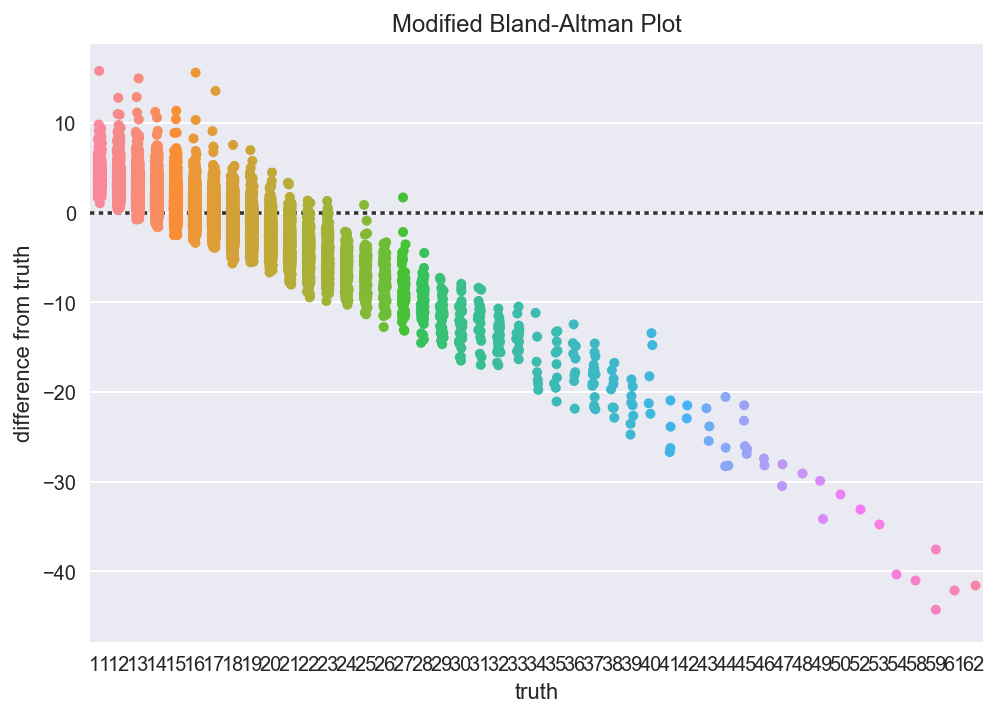

In [11]:
modified_bland_altman_plot(y_pred, y);

## Discussion
---

Our features are only the first ten temperatures of the cycle and the participant's last cycle length and follicular phase length. With it, we achieve a MSE of about 12, which beats the Bortot paper's 15. In terms of use case, this is about equal to the Bortot result.

In [12]:
df.L_PERIOD.median()

5.0

Now, the median period length is 5, which means that we are really using measurements of BBT during the period to determine the day of ovulation.

Since this model has only slight personalization, it's exciting to see how well a personalized model will do.